# Binning of temperature-dependent ARPES data using time-stamped external temperature data
In this example, we pull some temperature-dependent ARPES data from Zenodo, which was recorded as a continuous temperature ramp. We then add the respective temperature information from the respective timestamp/temperature values to the dataframe, and bin the data as function of temperature
For performance reasons, best store the data on a locally attached storage (no network drive). This can also be achieved transparently using the included MirrorUtil class.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

import sed
from sed.dataset import dataset

%matplotlib widget

## Load Data

In [2]:
dataset.get("TaS2") # Put in Path to a storage of at least 20 GByte free space.
data_path = dataset.dir
scandir, caldir = dataset.subdirs # scandir contains the data, caldir contains the calibration files

# correct timestamps if not correct timezone set
tzoffset = os.path.getmtime(scandir + '/Scan0121_1.h5') - 1594998158.0
if tzoffset:
    for file in glob.glob(scandir +'/*.h5'):
        os.utime(file, (os.path.getmtime(file)-tzoffset, os.path.getmtime(file)-tzoffset))

INFO - Not downloading TaS2 data as it already exists at "/home/runner/work/sed/sed/docs/tutorial/datasets/TaS2".
Set 'use_existing' to False if you want to download to a new location.


INFO - Using existing data path for "TaS2": "/home/runner/work/sed/sed/docs/tutorial/datasets/TaS2"


INFO - TaS2 data is already present.


In [3]:
# create sed processor using the config file with time-stamps:
sp = sed.SedProcessor(folder=scandir, user_config="../sed/config/mpes_example_config.yaml", time_stamps=True)

Folder config loaded from: [/home/runner/work/sed/sed/docs/tutorial/sed_config.yaml]
User config loaded from: [/home/runner/work/sed/sed/docs/sed/config/mpes_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]


In [4]:
# Apply jittering to X, Y, t, ADC columns.
sp.add_jitter()

  0%|          | 0/4 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=33, description='plane', max=297), IntSlider(value=3, description='width…

Button(description='apply', style=ButtonStyle())

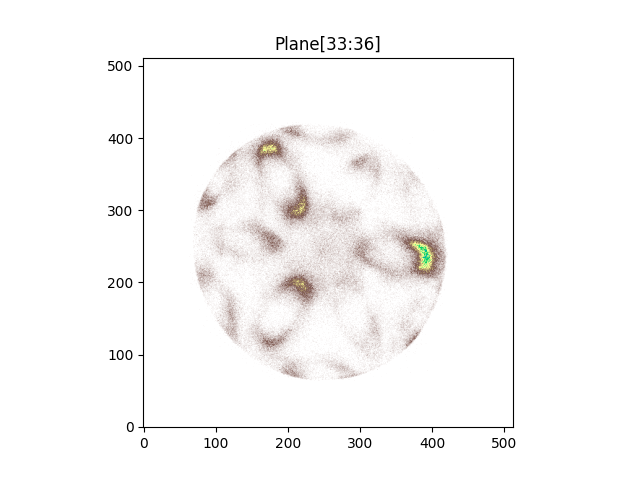

In [5]:
sp.bin_and_load_momentum_calibration(df_partitions=10, plane=33, width=3, apply=True)

interactive(children=(Dropdown(description='Point:', options=(0, 1, 2, 3, 4, 5, 6), value=0), Output()), _dom_…

interactive(children=(FloatText(value=337.0, description='point_x'), FloatText(value=242.0, description='point…

Button(description='apply', style=ButtonStyle())

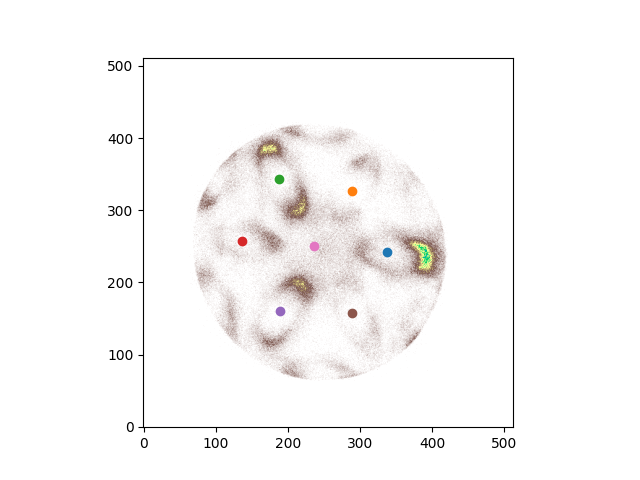

In [6]:
features = np.array([[337., 242.], [289., 327.], [187., 344.], [137., 258.], [189., 161.], [289., 158.], [236.0, 250.0]])
sp.define_features(features=features, rotation_symmetry=6, include_center=True, apply=True)
sp.generate_splinewarp(include_center=True)

interactive(children=(FloatSlider(value=1.0, description='scale', max=1.2, min=0.8, step=0.01), FloatSlider(va…

Button(description='apply', style=ButtonStyle())

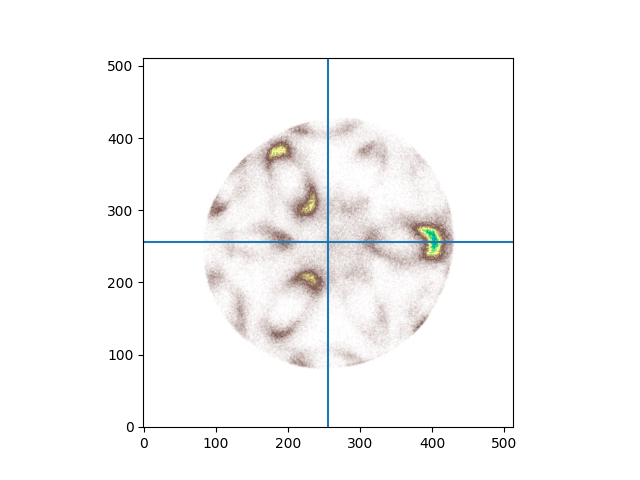

Output()

In [7]:
# Adjust pose alignment, using stored distortion correction
sp.pose_adjustment(xtrans=15, ytrans=8, angle=-5, apply=True)

In [8]:
# Apply stored momentum correction
sp.apply_momentum_correction()

Calculating inverse deformation field, this might take a moment...


In [9]:
# Apply stored config momentum calibration
sp.apply_momentum_calibration()

In [10]:
# Apply stored config energy correction
sp.apply_energy_correction()

  0%|          | 0/3 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=5, description='refid', max=10), IntRangeSlider(value=(65500, 66000), de…

Button(description='apply', style=ButtonStyle())

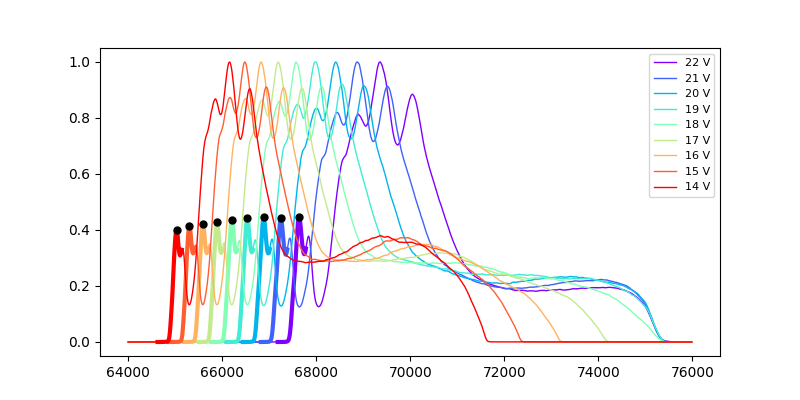

In [11]:
# Load energy calibration EDCs
scans = np.arange(127,136)
voltages = np.arange(22,13,-1)
files = [caldir + r'/Scan' + str(num).zfill(4) + '_1.h5' for num in scans]
sp.load_bias_series(data_files=files, normalize=True, biases=voltages, ranges=[(64000, 76000)])
rg = (65500, 66000)
sp.find_bias_peaks(ranges=rg, ref_id=5, infer_others=True, apply=True)
sp.calibrate_energy_axis(ref_energy=-0.5, ref_id=4, energy_scale="kinetic", method="lmfit")

In [12]:
# Apply stored config energy calibration
sp.append_energy_axis()

In [13]:
# add time-stamped temperature data
# either, directly retrieve data from EPICS archiver instance (within FHI network),
#sp.add_time_stamped_data(dest_column="T_B", archiver_channel="trARPES:Carving:TEMP-B")
# or use externally provided timestamp/data pairs
import h5py
with h5py.File(f"{data_path}/temperature_data.h5", "r") as file:
    data = file["temperatures"][()]
    time_stamps = file["timestamps"][()]
sp.add_time_stamped_data(dest_column="sample_temperature", time_stamps=time_stamps, data=data)

In [14]:
# inspect calibrated event histogram
axes = ['kx', 'ky', 'energy', 'sample_temperature']
ranges = [[-3, 3], [-3, 3], [-6, 2], [10, 300]]
sp.view_event_histogram(dfpid=80, axes=axes, ranges=ranges)

## Define the binning ranges and compute calibrated data volume

In [15]:
axes = ['kx', 'ky', 'energy', 'sample_temperature']
bins = [100, 100, 300, 100]
ranges = [[-2, 2], [-2, 2], [-6, 2], [20, 270]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges, normalize_to_acquisition_time="sample_temperature")

  0%|          | 0/33 [00:00<?, ?it/s]

Calculate normalization histogram for axis 'sample_temperature'...


## Some visualization:

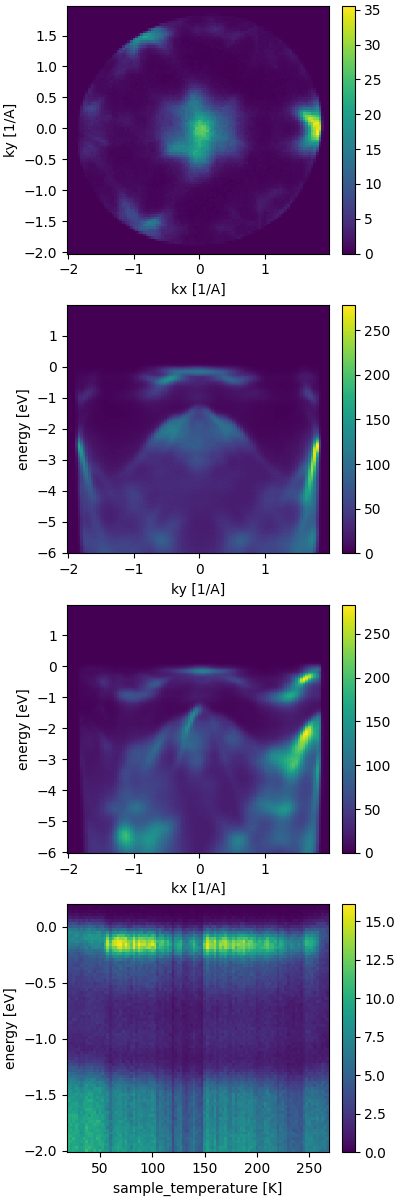

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(4, 12), constrained_layout=True)
res.loc[{'energy':slice(-.1, 0)}].sum(axis=(2,3)).T.plot(ax=axs[0])
res.loc[{'kx':slice(-.2, .2)}].sum(axis=(0,3)).T.plot(ax=axs[1])
res.loc[{'ky':slice(-.2, .2)}].sum(axis=(1,3)).T.plot(ax=axs[2])
res.loc[{'kx':slice(-.2, .2), 'ky':slice(-.2, .2), 'energy':slice(-2, 0.2)}].sum(axis=(0,1)).plot(ax=axs[3])

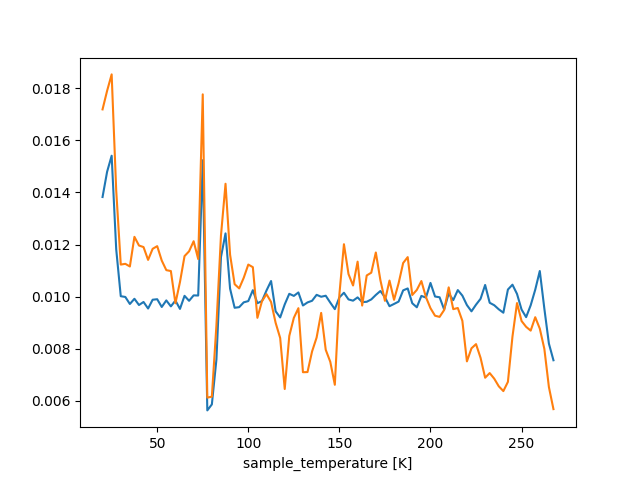

In [17]:
# Inspect effect of histogram normalization
fig, ax = plt.subplots(1,1)
(sp._normalization_histogram/sp._normalization_histogram.sum()).plot(ax=ax)
(sp._binned.sum(axis=(0,1,2))/sp._binned.sum(axis=(0,1,2,3))).plot(ax=ax)
plt.show()

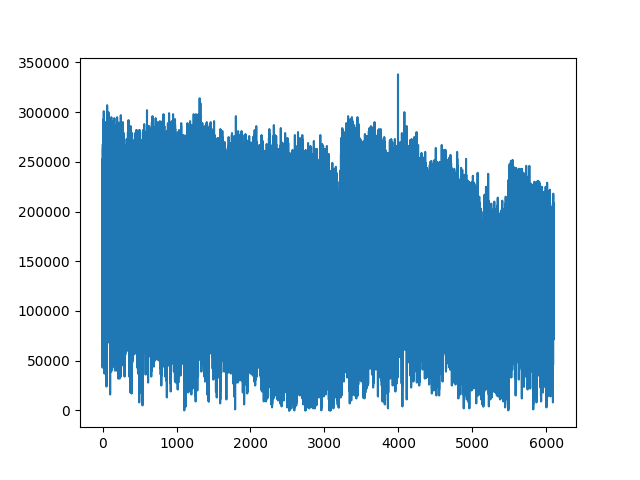

In [18]:
# Remaining fluctuations are an effect of the varying count rate throughout the scan
plt.figure()
rate, secs = sp.loader.get_count_rate()
plt.plot(secs, rate)

In [19]:
# Normalize for intensity around the Gamma point
res_norm = res.copy()
res_norm = res_norm/res_norm.loc[{'kx':slice(-.3, .3), 'ky':slice(-.3, .3)}].sum(axis=(0,1,2))

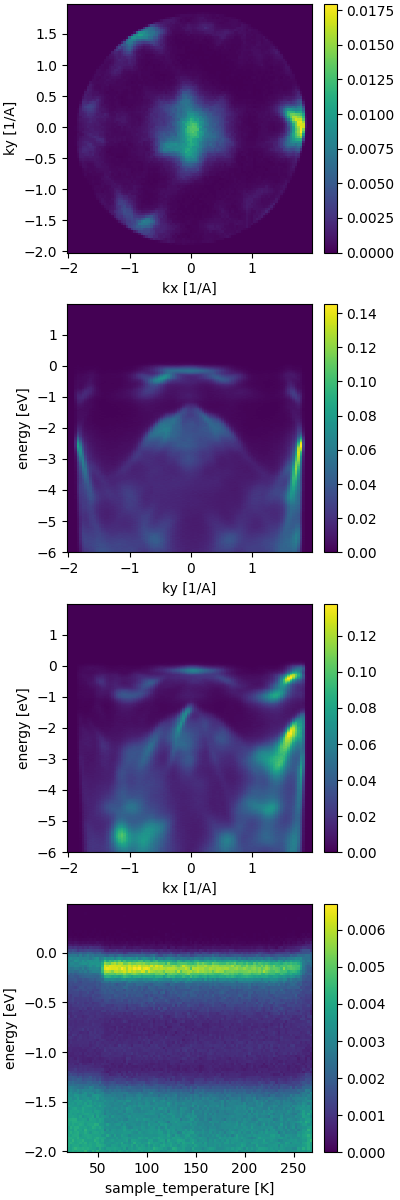

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(4, 12), constrained_layout=True)
res_norm.loc[{'energy':slice(-.1, 0)}].sum(axis=(2,3)).T.plot(ax=axs[0])
res_norm.loc[{'kx':slice(-.2, .2)}].sum(axis=(0,3)).T.plot(ax=axs[1])
res_norm.loc[{'ky':slice(-.2, .2)}].sum(axis=(1,3)).T.plot(ax=axs[2])
res_norm.loc[{'kx':slice(-.2, .2), 'ky':slice(-.2, .2), 'energy':slice(-2, 0.5)}].sum(axis=(0,1)).plot(ax=axs[3])

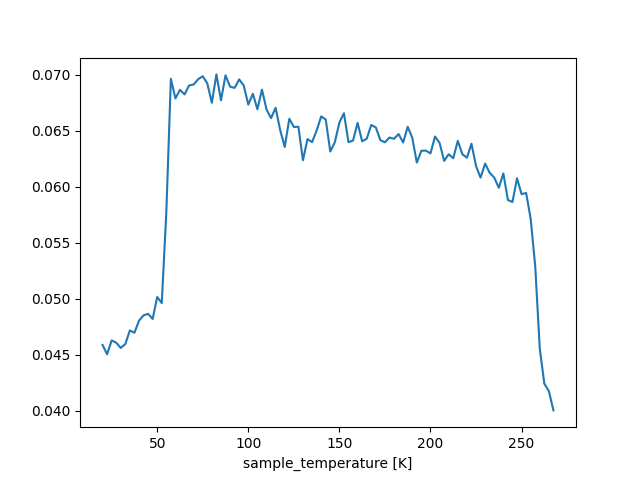

In [21]:
# Lower Hubbard band intensity versus temperature
plt.figure()
res_norm.loc[{'kx':slice(-.2, .2), 'ky':slice(-.2, .2), 'energy':slice(-.6, 0.1)}].sum(axis=(0,1,2)).plot()